Epoch 1/50


/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 0.0448
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - loss: 0.0103
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.0100
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.0084
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - loss: 0.0081
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.0068
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.0060
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.0063
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.0062
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 0.0062
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 0.0058
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 0.0061
Epoch 13/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.0056
Epoch 14/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - loss: 0.0057
Epoch 15/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.0054


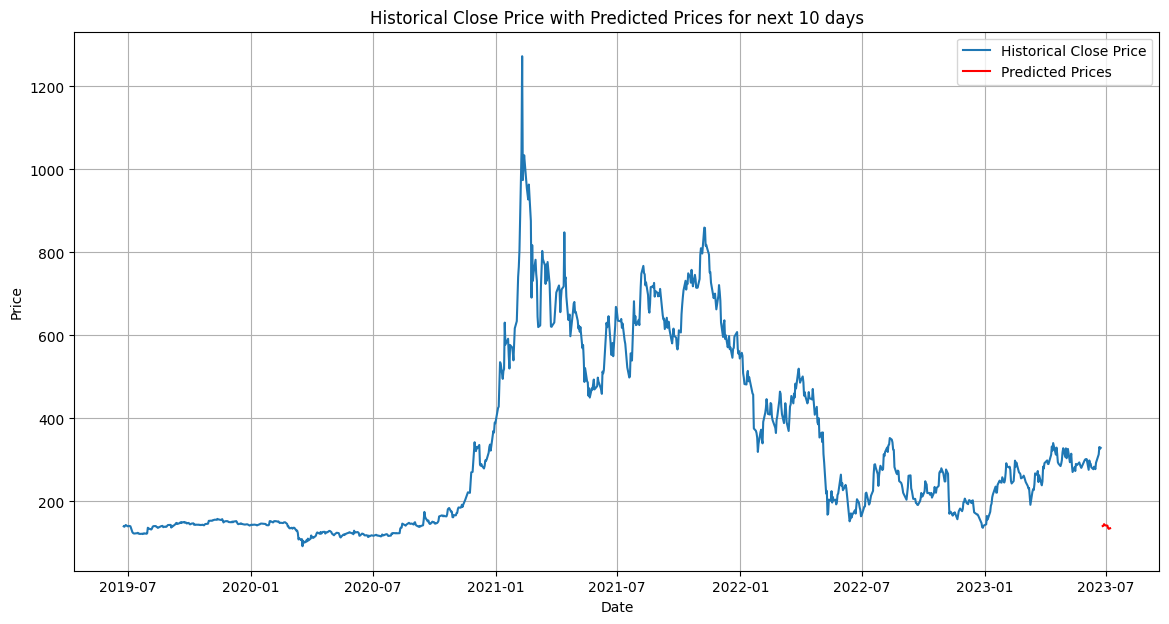

In [2]:
# 0. Import all libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# 1. Import data
file_path = './data/Microstrategy.csv'
data = pd.read_csv(file_path)

# Data Cleaning
columns_to_convert = ['Close/Last', 'Open', 'High', 'Low']
for column in columns_to_convert:
    data[column] = data[column].str.replace('$', '').str.replace(',', '').astype(float)

data['Date'] = pd.to_datetime(data['Date'])
train_set = data[(data['Date'] >= '2014-06-24') & (data['Date'] < '2023-06-24')].copy()

# 2. Setup Variables
time_steps = 90
future_steps = 10  # Number of future time steps to predict

# 3. Data pre-processing
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_set['Close/Last'].values.reshape(-1, 1))

# Initialize lists to store training data
x_train, y_train = [], []
for i in range(time_steps, len(train_data) - future_steps + 1):
    x_train.append(train_data[i - time_steps:i, 0])
    y_train.append(train_data[i:i + future_steps, 0])

# Convert lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# 4. Build Model
def build_model():
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(time_steps, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=future_steps))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 5. Training
def train_model(model, x_train, y_train):
    model.fit(x_train, y_train, epochs=50, batch_size=64)

# 6. Make Multi-Step Prediction
def make_multi_step_prediction(model, data, scaler, future_steps):
    last_data = data[-time_steps:]
    last_data = np.reshape(last_data, (1, last_data.shape[0], 1))
    
    predicted_prices = model.predict(last_data)
    predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))
    
    return predicted_prices

# Execute steps 4, 5, 6
model = build_model()
train_model(model, x_train, y_train)

# Predict future 10 days' Close/Last prices
predicted_prices = make_multi_step_prediction(model, train_data, scaler, future_steps=future_steps)

# Find the last date in the training set
last_date = train_set['Date'].max()
print(f"last_date:{last_date}")

future_dates = []
print(f"Predicted Close Prices for the next {future_steps} days:")
for i, price in enumerate(predicted_prices, 1):
    future_date = (last_date + pd.offsets.BDay(i)).strftime('%Y-%m-%d')
    future_date = pd.to_datetime(future_date)
    future_dates.append(future_date)
    print(f"Day {i} ({future_date}): {price[0]}")

# Plotting function
def plot_historical_and_predicted(train_set, predicted_prices, future_dates, future_steps):
    plt.figure(figsize=(14, 7))
    plt.plot(train_set['Date'], train_set['Close/Last'], label='Historical Close Price')
    plt.plot(future_dates, predicted_prices, color='red', label='Predicted Prices')
    plt.title(f'Historical Close Price with Predicted Prices for next {future_steps} days')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_historical_and_predicted(train_set, predicted_prices, future_dates, future_steps=future_steps)
